In [2]:
import sys
sys.path.insert(1, "../../../")

import torch
import torch.nn as nn
from torchviz import make_dot

In [3]:
from Models.yolov8cls_path import *

# Full C2f implementation by me (Bare + Res Connection + CSP + Hidden)

In [4]:
model = Model(num_classes=10, 
              residual_connection=True,
              CSP=True, 
              add_hidden=True,
              classifyV8=False,
              variant='s',
              device=None,
              dtype=torch.float32)

In [5]:
img = torch.rand(1,128,320,320)
c2f = model.c2f2
out = c2f(img)

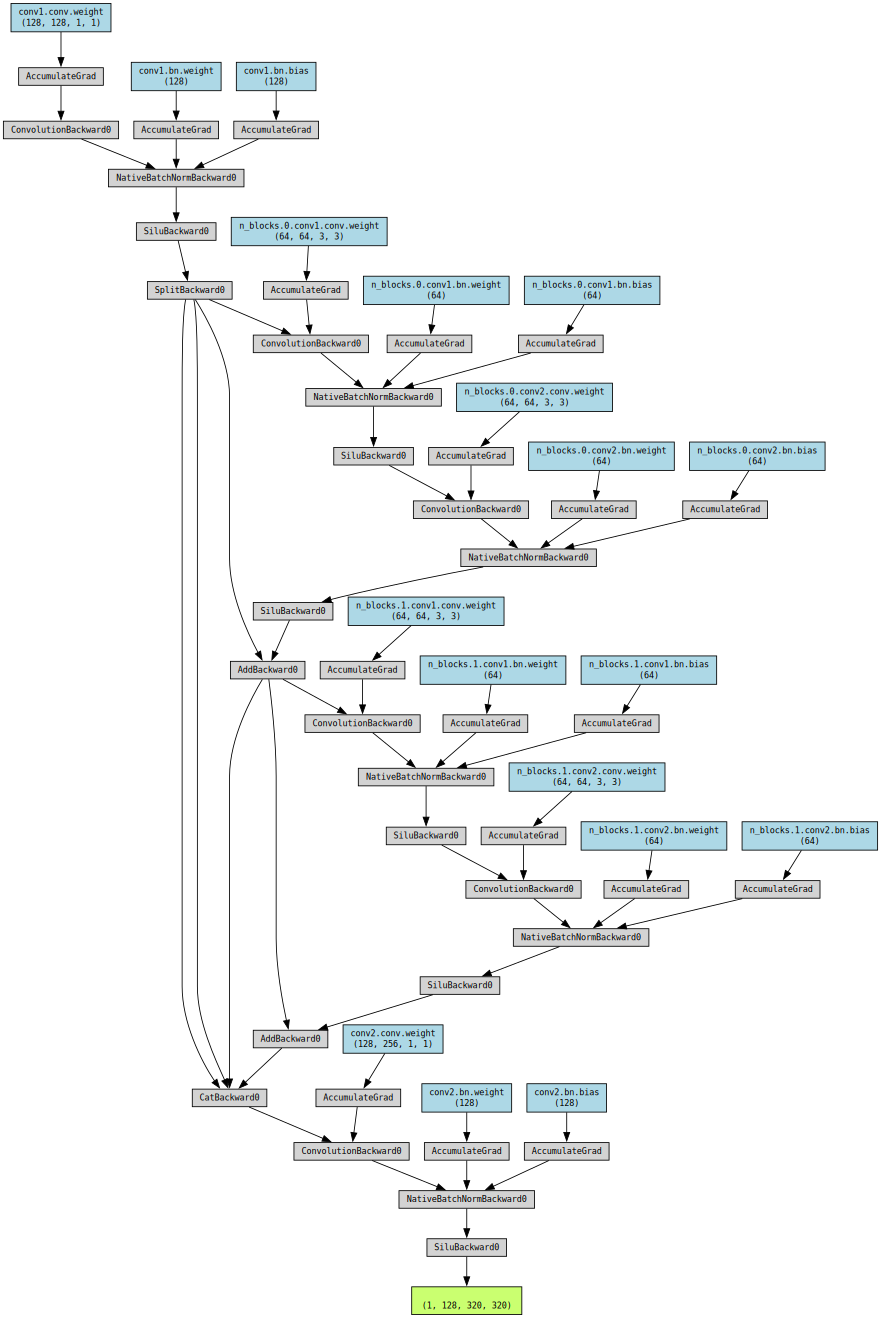

In [6]:
make_dot(out, params=dict(c2f.named_parameters()))

# C2f implementation by Ultralytics

In [7]:
def autopad(k, p=None, d=1):  # kernel, padding, dilation
    """Pad to 'same' shape outputs."""
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

In [8]:
class Conv(nn.Module):
    """Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)."""

    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        """Initialize Conv layer with given arguments including activation."""
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        """Apply convolution, batch normalization and activation to input tensor."""
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        """Perform transposed convolution of 2D data."""
        return self.act(self.conv(x))


In [9]:
class Bottleneck(nn.Module):
    """Standard bottleneck."""

    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 3), e=0.5):
        """Initializes a standard bottleneck module with optional shortcut connection and configurable parameters."""
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        """Applies the YOLO FPN to input data."""
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))

In [10]:
class C2f(nn.Module):
    """Faster Implementation of CSP Bottleneck with 2 convolutions."""

    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5):
        """Initializes a CSP bottleneck with 2 convolutions and n Bottleneck blocks for faster processing."""
        super().__init__()
        self.c = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv((2 + n) * self.c, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.ModuleList(Bottleneck(self.c, self.c, shortcut, g, k=((3, 3), (3, 3)), e=1.0) for _ in range(n))

    def forward(self, x):
        """Forward pass through C2f layer."""
        y = list(self.cv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))

In [11]:
img = torch.rand(1,32,320,320)
c2f = C2f(32, 32, n=2, shortcut=True)
out = c2f(img)

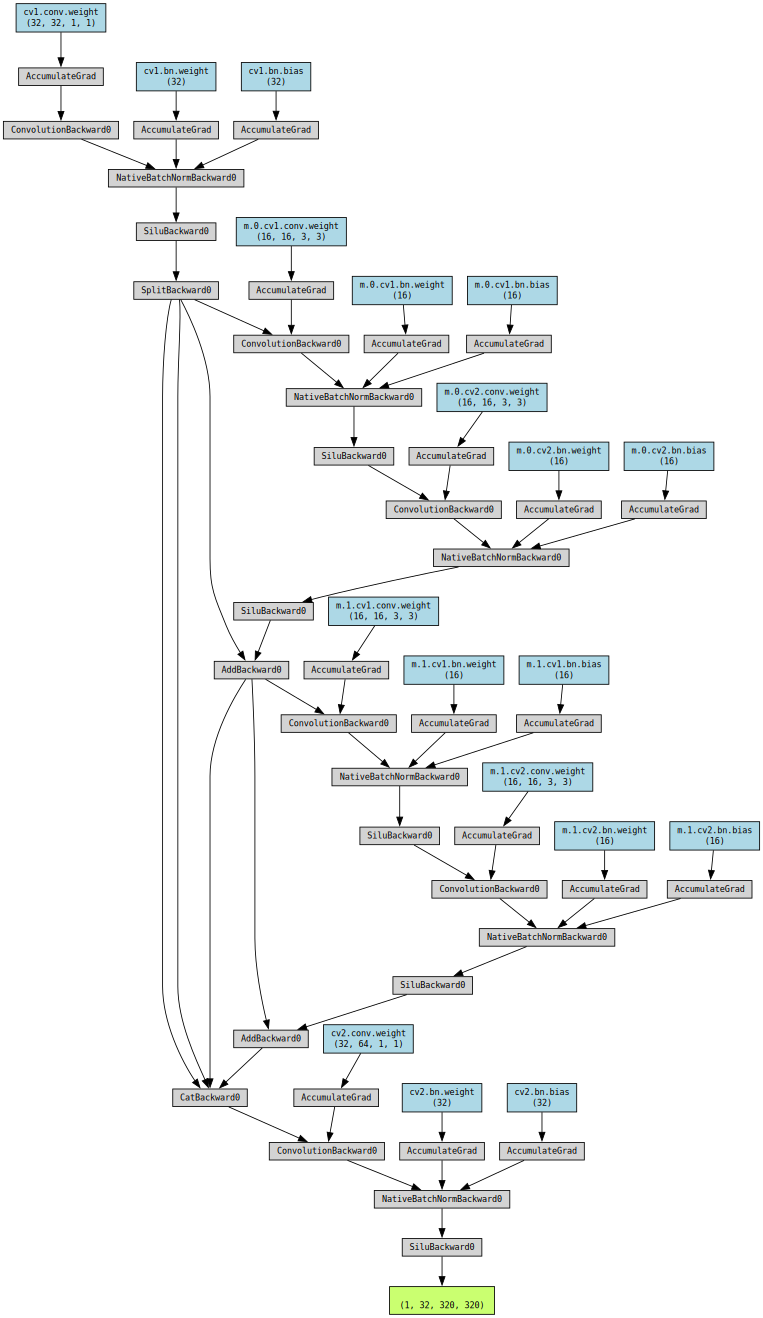

In [12]:
make_dot(out, params=dict(c2f.named_parameters()))